### 무게를 찾기
- 목표: 농어(Perch) 길이 피쳐를 사용해서 무게를 예측하기
- 데이터 셋: fish.csv
- 피쳐/속성: Length
- 타겟/라벨: Weight

#### [1] 데이터 준비 & 피쳐/타겟 분석

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [172]:
DATA_PATH = '../data/fish.csv'
fishDF = pd.read_csv(DATA_PATH)
fishDF.head(3)

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961


In [173]:
# mask = (fishDF['Species'] == 'Perch')
mask = fishDF.Species.isin(['Perch'])						# 강사님 Ver.
needDF = fishDF.loc[mask, ['Weight','Length']].copy().reset_index(drop=True)
needDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Weight  56 non-null     float64
 1   Length  56 non-null     float64
dtypes: float64(2)
memory usage: 1.0 KB


In [174]:
needDF.corr()

,Weight,Length
Weight,1.000000,0.958656
Length,0.958656,1.000000


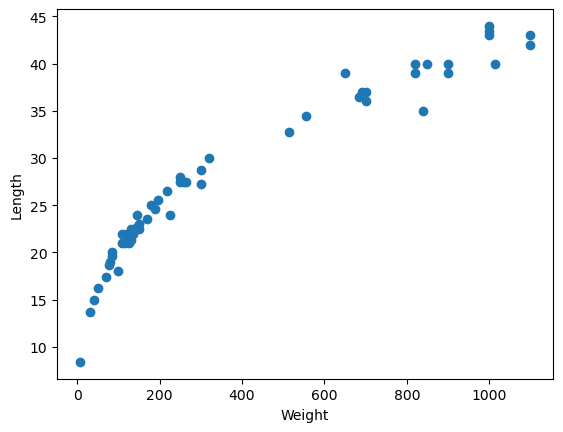

In [175]:
plt.scatter(needDF.Weight, needDF.Length)
plt.xlabel("Weight")
plt.ylabel("Length")
plt.show()

#### [2] 학습준비
- 학습 알고리즘: KNN Regressor
- 피쳐 스케일링 (normalization) 
- 학습용/테스트용 데이터셋 분리

##### [2_1] 피쳐와 타겟 분리
- 차원 확인 습관!

In [176]:
featureDF = needDF[['Length']]
targetSR = needDF['Weight']

print(f'featureDF: {featureDF.shape}, {featureDF.ndim}D')
print(f'targetSR: {targetSR.shape}, {targetSR.ndim}D')

featureDF: (56, 1), 2D
targetSR: (56,), 1D


##### [2_2] 학습용 & 테스트용 데이터셋 분리
- 전체 데이터셋 ==>  학습용:테스트용 = 80:20, 75:25, 70:30
- 회귀 데이터셋 ==>  데이터셋 구성 요소에 대한 비율 고려 X

In [177]:
from sklearn.model_selection import train_test_split

In [178]:
X_train, X_test, y_train, y_test = train_test_split(featureDF,
                                                    targetSR,
                                                    random_state=3
													)

In [179]:
print(f'X_train: {X_train.shape}, {X_train.ndim}D', f'y_train: {y_train.shape}, {y_train.ndim}D')
print(f'X_test: {X_test.shape}, {X_test.ndim}D', f'y_train: {y_test.shape}, {y_test.ndim}D')

X_train: (42, 1), 2D y_train: (42,), 1D
X_test: (14, 1), 2D y_train: (14,), 1D


In [180]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

##### [2_3] 피쳐 스케일링
- minmaxscaler

In [181]:
from sklearn.preprocessing import MinMaxScaler

In [182]:
# 스케일러 인스턴스 생성
mmScaler = MinMaxScaler()

In [183]:
# 스케일러에 데이터셋 전용 속성값 설정
mmScaler.fit(X_train)						# 기준 Scaler 생성

MinMaxScaler()

In [184]:
mmScaler.min_, mmScaler.scale_, mmScaler.data_min_, mmScaler.data_max_

(array([-0.23931624]), array([0.02849003]), array([8.4]), array([43.5]))

In [185]:
# 학습용/테스트용 데이터셋 전용 속성값 설정
X_train_scaled = mmScaler.transform(X_train)			# X_train으로 생성한 Scaler 기준으로 값 변환

X_test_scaled = mmScaler.transform(X_test)				# X_train으로 생성한 Scaler 기준으로 값 변환

#### [3] 학습진행

In [186]:
from sklearn.neighbors import KNeighborsClassifier

# 데이터
X = [[0], 	[1], [2], [3]]
y = [0, 	0, 	  1,   1]

neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X, y)
print(neigh.predict([[1.]]))
#print(neigh.predict_proba([[0.9]]))

[0]


In [187]:
dist, index = neigh.kneighbors([[1.]])
print(dist)
print()
print(index)

[[0. 1.]]

[[1 0]]


In [188]:
dist, index = neigh.kneighbors()
print(dist)
print()
print(index)

[[1. 2.]
 [1. 1.]
 [1. 1.]
 [1. 2.]]

[[1 2]
 [0 2]
 [1 3]
 [2 1]]


In [189]:
from sklearn.neighbors import KNeighborsRegressor

In [190]:
model = KNeighborsRegressor()

In [191]:
model.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [192]:
model.n_features_in_, model.n_samples_fit_, model.effective_metric_, model.effective_metric_params_

(1, 42, 'euclidean', {})

#### [4] 최적 K 찾기

In [193]:

scores = {}
for k in range(1, model.n_samples_fit_ + 1):
	# 최근접 이웃 기준 개수 선언 --> 하이퍼파라미터 (모델 성능 좌우)
	model.n_neighbors = k

	# 성능평가
	score= model.score(X_test_scaled, y_test)
	
	scores[k] = score

In [194]:
list(scores.keys())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42]

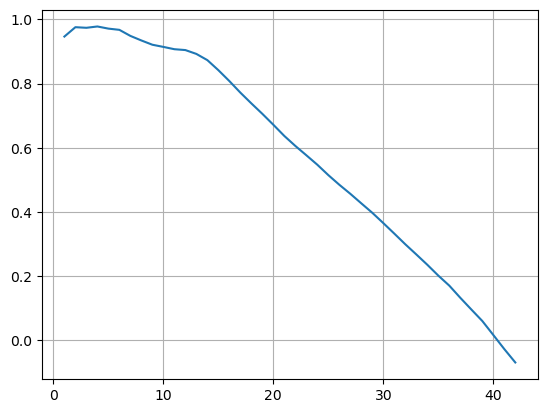

In [195]:
plt.plot(list(scores.keys()), list(scores.values()))
plt.grid()
plt.show()

In [196]:
# value 값이 가장 높은 key 값이 필요하므로 -> x[1] 기준
sort_k = sorted(scores.items(), key=lambda x: x[1], reverse=True)

print(sort_k[:5])
best_k	 = sort_k[0][0]	
best_k	

[(4, 0.9778645975773987), (2, 0.9756453612944208), (3, 0.9737525259938322), (5, 0.971202718105763), (6, 0.9673654260912912)]


4

In [197]:
# 모델에 적용
model.n_neighbors = best_k

#### [5] 새로운 데이터의 무게 예측

In [198]:
new_length = float( input("농어 길이:  ").strip() )
print(f'new_length: {new_length}')

new_length: 40.0


In [199]:
# 2D 변환, 스케일링(Scaler) 적용
# 학습 피쳐 --> DF!! --> 맞춰야!!
dataDF = pd.DataFrame( [[new_length]], columns=['Length'])
dataDF

,Length
0,40.0


In [200]:
# 피쳐 스케일링
# X_train Scaler로 스케일링!!
new_data_scaled = mmScaler.transform(dataDF)
new_data_scaled

array([[0.9002849]])

In [201]:
# 예측
model.predict(new_data_scaled)

array([896.25])

##### 예측값 단계 확인

In [202]:
dist, idx = model.kneighbors(new_data_scaled)
print(dist)
print()
print(idx)

[[0. 0. 0. 0.]]

[[10 30 14 31]]


In [206]:
X_train_scaled.reshape(-1)[[10, 30, 14, 31]]

array([0.9002849, 0.9002849, 0.9002849, 0.9002849])

In [207]:
y_train[[10, 30, 14, 31]]

10     850.0
30     820.0
14    1015.0
31     900.0
Name: Weight, dtype: float64

In [208]:
y_train[[10, 30, 14, 31]].mean()
# y_train[idx.reshape(-1)].mean()

896.25

#### [KNN 단점]
		- 학습 데이터셋의 min,max 범위 밖 새로운 데이터에 대해 예측 정확도 급격 하락

In [212]:
# 임의의 새로운 데이터
new_length = 3
# 2D DF
dataDF = pd.DataFrame( [[new_length]], columns=['Length'])
# 피쳐 스케일링
data_scaled = mmScaler.transform(dataDF)

In [213]:
# 예측
model.predict(data_scaled)

array([32.35])

In [209]:
y_train[[10, 30, 14, 31]].sum()/model.n_neighbors

896.25